# Flocode #049 - Pynite 01: Introduction to Finite Element Models in Python

From [Flocode Newsletter #049](flocode.substack.com)

For a detailed walkthrough of the code, please see the README.md file in the project's root folder.

+----------------+
| Statics Check: |
+----------------+

+------------------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+---------+
| Load Combination | Sum FX | Sum RX | Sum FY | Sum RY | Sum FZ | Sum RZ | Sum MX | Sum RMX | Sum MY | Sum RMY | Sum MZ | Sum RMZ |
+------------------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+---------+
|       1.4D       |   0    |   0    |  -266  |  266   |   0    |   0    |   0    |    0    |   0    |    0    |  -798  |   798   |
|    1.2D+1.6L     |   0    |   0    |  -188  |  188   |   0    |   0    |   0    |    0    |   0    |    0    |  -720  |   720   |
|  1.2D+1.6L+0.5S  |   0    |   0    |  -55   |   55   |   0    |   0    |   0    |    0    |   0    |    0    |  -321  |   321   |
+------------------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+---------+



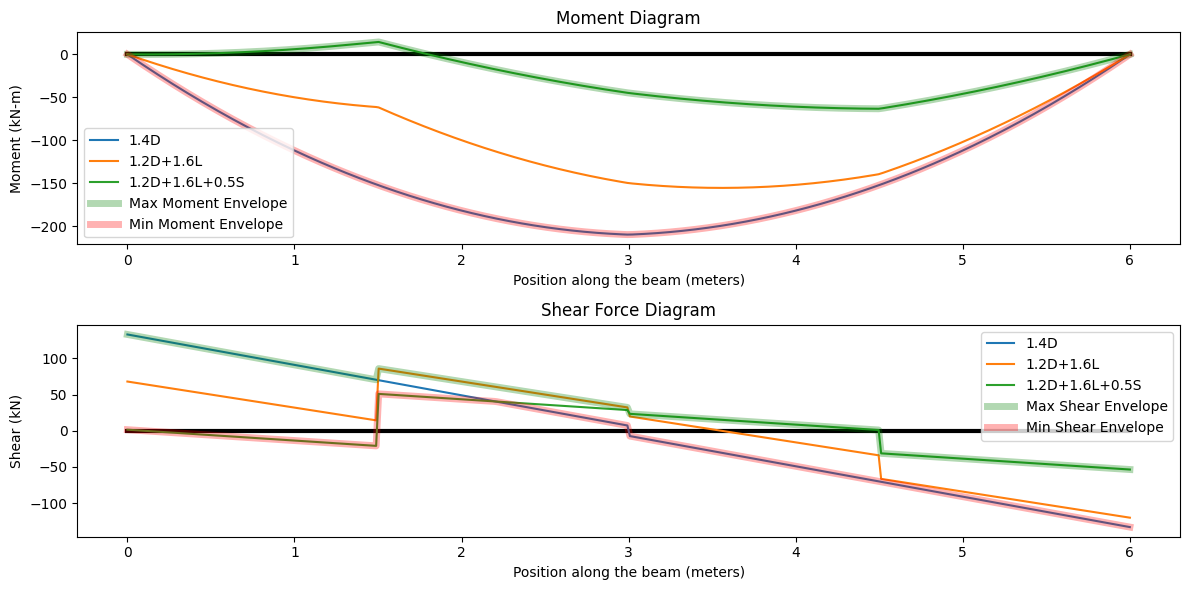

In [10]:
# Import `FEModel3D` from `PyNite`
from PyNite import FEModel3D
from matplotlib import pyplot as plt
import numpy as np

# Import 'Visualization' for rendering the model
from PyNite import Visualization

# Create a new finite element model
simple_beam = FEModel3D()

# Add nodes (6 meters apart)
simple_beam.add_node('N1', 0, 0, 0)
simple_beam.add_node('N2', 6, 0, 0)  # 6 meters

# Define a material
E = 210000  # Modulus of elasticity (MPa)
G = 81000   # Shear modulus of elasticity (MPa)
nu = 0.3    # Poisson's ratio
rho = 7.85  # Density (kg/m^3)
simple_beam.add_material('Steel', E, G, nu, rho)

# Add a beam with the following properties:
# Iy = 1.2e-4 m^4, Iz = 1.6e-4 m^4, J = 2.7e-4 m^4, A = 0.025 m^2
simple_beam.add_member('M1', 'N1', 'N2', 'Steel', 1.2e-4, 1.6e-4, 2.7e-4, 0.025)

# Provide simple supports
simple_beam.def_support('N1', True, True, True, False, False, False)
simple_beam.def_support('N2', True, True, True, True, False, False)

# Add a uniform load of 20 kN/m to the beam
simple_beam.add_member_dist_load('M1', 'Fy', -30, -30, 0, 6, 'D')

# Add point loads at different positions
simple_beam.add_member_pt_load('M1', 'Fy', -10, 3, 'D')  # 10 kN Dead load at midspan (3 meters)
simple_beam.add_member_pt_load('M1', 'Fy', 45, 1.5, 'L')  # 45 kN Live load at quarter span (1.5 meters)
simple_beam.add_member_pt_load('M1', 'Fy', -20, 4.5, 'L')  # 5 kN Live load at three-quarter span (4.5 meters)

# Add load combinations
simple_beam.add_load_combo('1.4D', {'D': 1.4})
simple_beam.add_load_combo('1.2D+1.6L', {'D': 1.2, 'L': 1.6})
simple_beam.add_load_combo('1.2D+1.6L+0.5S', {'D': 0.5, 'L': 1.6, 'S': 0.5})

# Analyze the beam and perform a statics check
simple_beam.analyze(check_statics=True)

# Set PyVista Jupyter backend, 'static' for static images or 'panel' for an interactive plot
import pyvista as pv
pv.set_jupyter_backend('static')  # Use 'static' backend for simplicity

# Visualization using PyNite's render_model function
Visualization.render_model(simple_beam, annotation_size=0.1, deformed_shape=True, deformed_scale=0.1, render_loads=True, combo_name='1.2D+1.6L')

# Plot the moment diagram with all load cases and max/min envelope
x, M1 = simple_beam.members['M1'].moment_array("Mz", n_points=400, combo_name='1.4D')
_, M2 = simple_beam.members['M1'].moment_array("Mz", n_points=400, combo_name='1.2D+1.6L')
_, M3 = simple_beam.members['M1'].moment_array("Mz", n_points=400, combo_name='1.2D+1.6L+0.5S')

max_moment_envelope = np.maximum(np.maximum(M1, M2), M3)
min_moment_envelope = np.minimum(np.minimum(M1, M2), M3)

plt.figure(figsize=(12, 6))

# Moment Diagram
plt.subplot(2, 1, 1)
plt.plot(x, np.zeros(len(x)), c="black", lw=3)
plt.plot(x, M1, label='1.4D')
plt.plot(x, M2, label='1.2D+1.6L')
plt.plot(x, M3, label='1.2D+1.6L+0.5S')
plt.plot(x, max_moment_envelope, alpha=0.3, c="green", lw=5, label='Max Moment Envelope')
plt.plot(x, min_moment_envelope, alpha=0.3, c="red", lw=5, label='Min Moment Envelope')
plt.legend()
plt.xlabel('Position along the beam (meters)')
plt.ylabel('Moment (kN-m)')
plt.title('Moment Diagram')

# Shear Diagram
x, V1 = simple_beam.members['M1'].shear_array("Fy", n_points=400, combo_name='1.4D')
_, V2 = simple_beam.members['M1'].shear_array("Fy", n_points=400, combo_name='1.2D+1.6L')
_, V3 = simple_beam.members['M1'].shear_array("Fy", n_points=400, combo_name='1.2D+1.6L+0.5S')

max_shear_envelope = np.maximum(np.maximum(V1, V2), V3)
min_shear_envelope = np.minimum(np.minimum(V1, V2), V3)

plt.subplot(2, 1, 2)
plt.plot(x, np.zeros(len(x)), c="black", lw=3)
plt.plot(x, V1, label='1.4D')
plt.plot(x, V2, label='1.2D+1.6L')
plt.plot(x, V3, label='1.2D+1.6L+0.5S')
plt.plot(x, max_shear_envelope, alpha=0.3, c="green", lw=5, label='Max Shear Envelope')
plt.plot(x, min_shear_envelope, alpha=0.3, c="red", lw=5, label='Min Shear Envelope')
plt.legend()
plt.xlabel('Position along the beam (meters)')
plt.ylabel('Shear (kN)')
plt.title('Shear Force Diagram')

plt.tight_layout()
plt.show()